In [10]:
import temporian as tp

import pandas as pd
import numpy as np

In [11]:
# Generate a synthetic dataset
timestamps = np.arange(0, 100, 0.1)
n = len(timestamps)
noise = 0.1 * np.random.randn(n)
trend = 0.01 * timestamps
season = 0.4 * np.sin(0.5 * timestamps)

raw_data = pd.DataFrame(
    {
        "timestamp": timestamps,
        # "noise": noise,
        # "trend": trend,
        # "seasoon": season,
        "signal": noise + trend + season,
    }
)

raw_data

,timestamp,signal
0,0.0,0.006520
1,0.1,0.322398
2,0.2,0.079459
3,0.3,-0.024017
4,0.4,0.005150
...,...,...
995,99.5,0.924792
996,99.6,0.748921
997,99.7,0.907597
998,99.8,0.808576


In [12]:
# Convert the dataset into a Temporian dataset

source_data = tp.EventSet.from_dataframe(raw_data)

source_data

indexes: []
features: [('signal', float64)]
events:
     (1000 events):
        timestamps: [ 0.   0.1  0.2 ... 99.7 99.8 99.9]
        'signal': [0.0065 0.3224 0.0795 ... 0.9076 0.8086 0.9571]

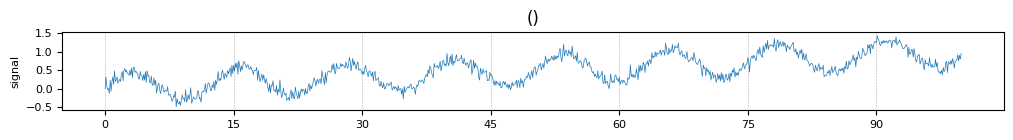

In [13]:
# Plot the dataset
_ = source_data.plot()

In [14]:
# Compute some signals
source = source_data.node()

signal = source["signal"]
trend = tp.simple_moving_average(signal, 50)
detrend = signal - trend
trend2 = tp.simple_moving_average(detrend, 10)
detrend2 = detrend - trend2
slope = trend2 - tp.sample(tp.lag(trend2, 5), trend2)

# TODO: Clean feature names with rename.
result = tp.glue(
    signal,
    tp.prefix("trend.", trend),
    tp.prefix("detrend.", detrend),
    tp.prefix("trend2.", trend2),
    tp.prefix("detrend2.", detrend2),
    tp.prefix("slope.", slope),
)

result_data = tp.evaluate(result, {source: source_data})

result_data

indexes: []
features: [('signal', float64), ('trend.signal', float64), ('detrend.sub_signal_signal', float64), ('trend2.sub_signal_signal', float64), ('detrend2.sub_sub_signal_signal_sub_signal_signal', float64), ('slope.sub_sub_signal_signal_sub_signal_signal', float64)]
events:
     (1000 events):
        timestamps: [ 0.   0.1  0.2 ... 99.7 99.8 99.9]
        'signal': [0.0065 0.3224 0.0795 ... 0.9076 0.8086 0.9571]
        'trend.signal': [0.0065 0.1645 0.1361 ... 0.7495 0.7501 0.7514]
        'detrend.sub_signal_signal': [ 0.      0.1579 -0.0567 ...  0.1581  0.0584  0.2057]
        'trend2.sub_signal_signal': [0.     0.079  0.0338 ... 0.2275 0.2218 0.2175]
        'detrend2.sub_sub_signal_signal_sub_signal_signal': [ 0.      0.079  -0.0904 ... -0.0694 -0.1633 -0.0118]
        'slope.sub_sub_signal_signal_sub_signal_signal': [    nan     nan     nan ... -0.0973 -0.1049 -0.1129]

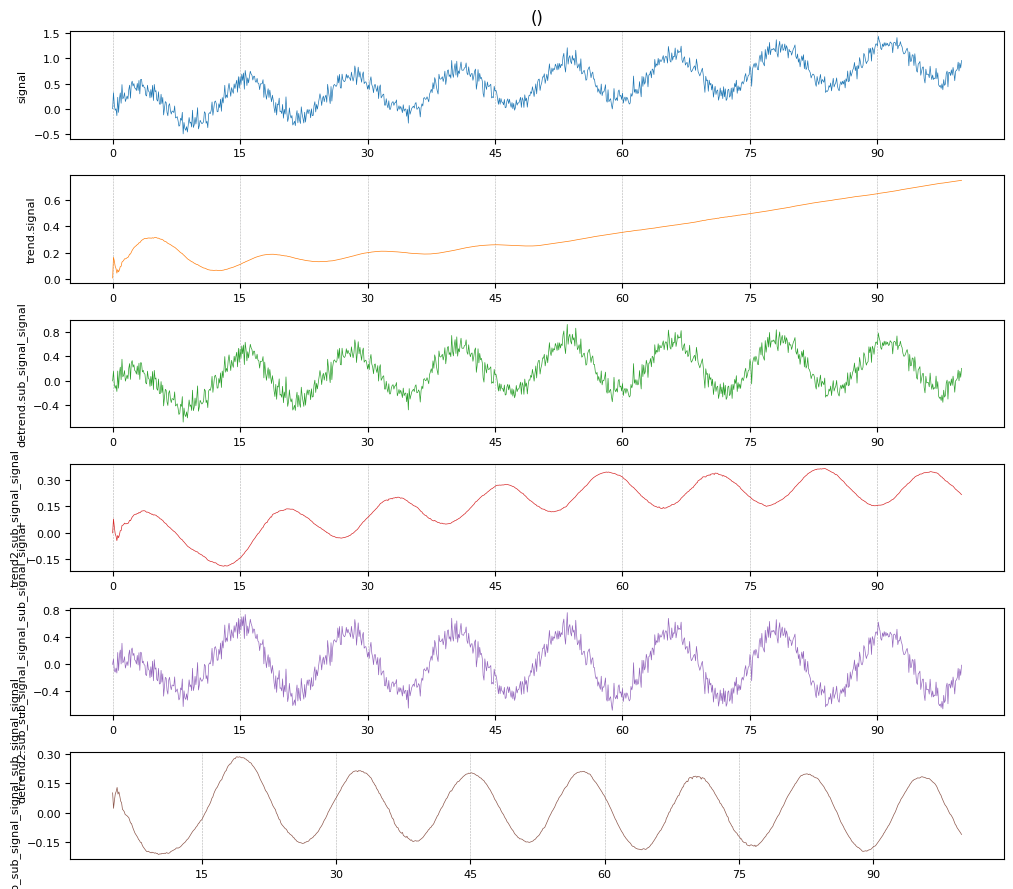

In [15]:
# Plot the results
result_data.plot()